In [1]:
from skimage import io, color
import matplotlib.pyplot as plt
from skimage import exposure
import pylab
import cv2 as cv
# from tqdm import tqdm
import matplotlib.image as mpimg
import numpy as np
import scipy as scp
from PIL import Image, ImageDraw
from scipy.signal import convolve2d
import time
from pyunlocbox import functions
from pyunlocbox import solvers
import pyunlocbox
from skimage import img_as_float
import matplotlib
from skimage.io import imread
from skimage.measure import compare_psnr
matplotlib.use('PDF')
plt.style.use('ggplot') 
%matplotlib inline

# Functions

In [2]:
def FISTA(y, A, norma, tau = 100.):
    if norma == 1:
        f1 = functions.norm_l1(maxit=50, dim=2)
    else:
        f1 = functions.norm_tv(maxit=50, dim=2)
        
    f2 = functions.norm_l2(y =y, A = A, lambda_=tau)
    solver = solvers.forward_backward(step=0.5/tau)
    x0 = np.array(y)  # Make a copy to preserve im_masked.
    ret = solvers.solve([f1, f2], x0, solver, maxit=100)#, verbosity='ALL')
    return ret

def IST(y, A, norma, tau = 100.):
    if norma == 1:
        f1 = functions.norm_l1(maxit=50, dim=2)
    else:
        f1 = functions.norm_tv(maxit=50, dim=2)
        
    f2 = functions.norm_l2(y =y, A = A, lambda_=tau)
 
    x0_IST = np.array(y)  
    solver_IST = solvers.forward_backward(step=0.5/tau, accel = pyunlocbox.acceleration.dummy())
    
    IST = solvers.solve([f1, f2], x0_IST, solver_IST, maxit=100)#, verbosity='ALL')
    return IST

In [3]:
def tv_norm(x):
    h = np.array([0, 1, -1]).reshape(1,-1)
    v = h.T
    h = convolve2d(x, h, boundary='wrap', mode='same')
    v = convolve2d(x, v, boundary='wrap', mode='same')
    return np.sum(np.sqrt(h**2 + v**2))

def soft_1(a, T):
    return np.sign(a)*np.max([abs(a)-T, 0])

soft = np.vectorize(soft_1)

def divergence(p1, p2):
    u = np.empty(p1.shape)
    v = np.empty(p2.shape)
    
    z = p1[1:-1,:] - p1[:-2,:]
    u[0,:] = p1[0,:]
    u[1:-1,:] = z
    u[-1,:] = -p1[-1,:]

    z = p2[:,1:-1] - p2[:,:-2]
    v[:,0] = p2[:,0]
    v[:,1:-1] = z
    v[:,-1] = - p2[:,-1]

    return v + u

def gradient(u):
    z = u[1:, :] - u[:-1,:]
    dux = np.append(z, np.zeros(z.shape[1]).reshape(1,-1), axis = 0)

    z = u[:,1:] - u[:,:-1]
    duy = np.append(z, np.zeros(z.shape[0]).reshape(-1,1), axis = 1)
    
    return dux, duy

def chambolle(x, px, py, threshold=1, max_iter=20, tol=1e-3):
    cont = 1
    k = 0
    tau = 0.249
    
    while cont: 
        k += 1
        divp = divergence(px,py) 
        u = divp - x / threshold
        upx, upy = gradient(u)
        tmp = np.sqrt(upx**2 + upy**2)
        err = np.sum((- upx + tmp * px)**2 + (- upy + tmp * py)**2)**0.5
        px = (px + tau * upx) / (1 + tau * tmp)
        py = (py + tau * upy) / (1 + tau * tmp)
        cont = ((k < max_iter) & (err > tol))

    f = x - threshold * divergence(px, py)
    return f, px, py

In [4]:
def salsa(y, A, AT, tau, mu, true_x, invLS, thres, norma,  max_iter = 100, tolA = 1e-5):
    M, N = y.shape
    
    # initializing
    x = np.zeros(y.shape)
    u = x.copy()
    bu = 0 * u
    if norma == soft:
        psi = soft
        phi = lambda x: np.sum(np.abs(u)) # l1-norm
    else:
        phi = tv_norm
    
    threshold = tau/mu

    # compute and store initial value of the objective function
    resid =  y - A(x)
    resid = np.reshape(resid, order='f', newshape=(resid.shape[0]*resid.shape[1]))
    num_A = 1
    f = [0.5 * (resid.T.dot(resid)) + tau * phi(u)]
    
    mses = [np.sum((x - true_x)**2)/(M*N)]
    
    pux = 0 * u
    puy = 0 * u
    
    for i in range(max_iter):
        if norma == soft:
#             u = psi(x - bu, threshold) # for soft
            u = psi(x - bu, thres) # for soft
        else:
            u, pux, puy = chambolle(np.real(x - bu), pux, puy, threshold, 10)
        r = AT(y) + mu * (u + bu)
        x = invLS(r)
        bu = bu + (u - x)
        resid =  y - A(x)
        resid = np.reshape(resid, order='f', newshape=(resid.shape[0]*resid.shape[1]))
        num_A += 1
        f.append(0.5 * (resid.T.dot(resid)) + tau * phi(u))
        mses.append(np.sum((x - true_x)**2)/(M*N))
        
        if np.abs((f[i+1]-f[i])/f[i]) < tolA:
            return x, f, mses 
    
    return x, f, mses

# Image

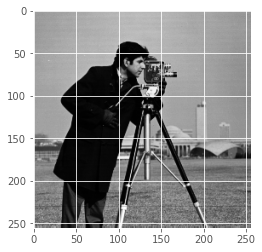

In [6]:
im_original = mpimg.imread('cameraman.tif')
plt.imshow(im_original, cmap='gray')
im_original = 1.*(im_original - np.min(im_original))/np.max(im_original)

# Part 1: Image deblurring

In [7]:
# Image deblurring, with total variation. 9*9 uniform blur, and Gaussian noise (SNR = 40 dB).

# original image
x = np.array(im_original) 
M, N = x.shape

# function handle for uniform blur operator (acts on the image coefficients)
h = np.ones(9)
lh = len(h)
h = h / np.sum(h);
h = np.append(h, np.zeros(len(x)-len(h)))
h = np.roll(h, -(lh - 1) // 2)
h = h.reshape(-1,1)
h = h.dot(h.T)

H_FFT = np.fft.fft2(h)
HC_FFT = np.conj(H_FFT)

# observation
A = lambda x: np.real(np.fft.ifft2(np.multiply(H_FFT,np.fft.fft2(x))))
AT = lambda x: np.real(np.fft.ifft2(np.multiply(HC_FFT,np.fft.fft2(x))))

# algorithm parameters
tau_1 = 2.5e-2 # reg parameter
mu_1 = tau_1/10.

tau_tv = 0.001 # reg parameter
mu_tv = tau_tv/10.

num_iters = 500
tol = 1e-5

def invLS_mu(mu):
    
    filter_FFT = 1 / (np.abs(H_FFT)**2 + mu)
    invLS = lambda x: np.real(np.fft.ifft2(filter_FFT * np.fft.fft2(x)))
    
    return invLS

SNR = 40
sigma = np.linalg.norm(A(x) - np.mean(A(x)), 'fro') / np.sqrt(N * M * 10**(SNR / 10))
y = A(x) + sigma * np.random.randn(M,N)

In [8]:
start = time.process_time() 
x_salsa, f, mses = salsa(y, A, AT, tau_tv, mu_tv, x, invLS_mu(mu_tv), 0, norma = tv_norm)
elapsed = (time.process_time() - start)

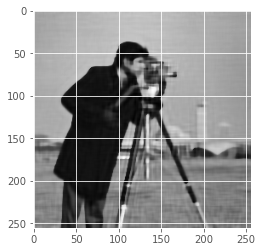

In [9]:
plt.imshow(x_salsa, cmap='gray')

In [10]:
start_soft = time.process_time() 
x_salsa_soft, f_soft, mses_soft = salsa(y, A, AT, tau_1, mu_1, x, invLS_mu(mu_1), 0.0191, norma = soft)
elapsed_soft = (time.process_time() - start_soft)

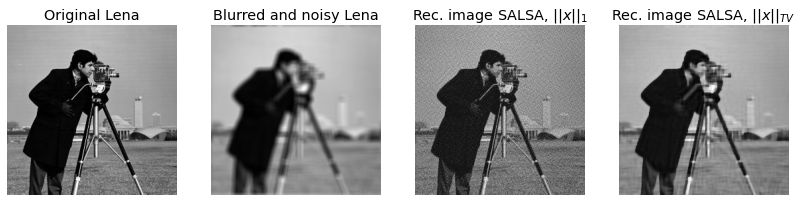

In [11]:
fig = plt.figure(figsize=(14,5))
axes = fig.subplots(1, 4, sharey=True, sharex=True)
axes[0].imshow(x, cmap='gray')
axes[0].set_title('Original Lena')
axes[0].axis('off')
axes[1].imshow(y, cmap='gray')
axes[1].set_title('Blurred and noisy Lena')
axes[1].axis('off')
axes[2].imshow(x_salsa_soft, cmap='gray')
axes[2].set_title('Rec. image SALSA, $\|\| x \|\|_1$')
axes[2].axis('off')
axes[3].imshow(x_salsa, cmap='gray')
axes[3].set_title('Rec. image SALSA, $\|\| x \|\|_{TV}$')
axes[3].axis('off')

plt.savefig('deblur_SALSA'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

In [12]:
ret_1norm = FISTA(y, A, norma = 1)

Solution found after 11 iterations:
    objective function f(sol) = 2.894766e+04
    stopping criterion: RTOL


In [13]:
ret_tv_norm = FISTA(y, A, norma = 2)

Solution found after 15 iterations:
    objective function f(sol) = 1.322651e+03
    stopping criterion: RTOL


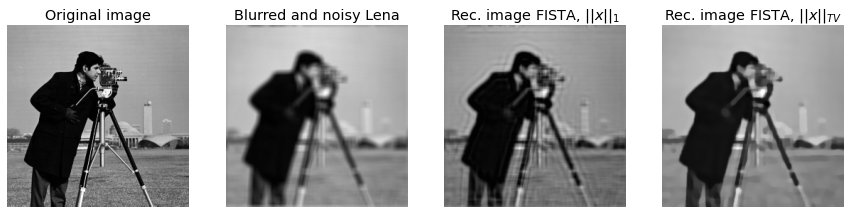

In [14]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 4, 1)
_ = ax1.imshow(x, cmap='gray')
_ = ax1.axis('off')
_ = ax1.set_title('Original image')
ax2 = fig.add_subplot(1, 4, 2)
_ = ax2.imshow(y, cmap='gray')
_ = ax2.axis('off')
_ = ax2.set_title('Blurred and noisy Lena')
ax3 = fig.add_subplot(1, 4, 3)
_ = ax3.imshow(ret_1norm['sol'], cmap='gray')
_ = ax3.axis('off')
_ = ax3.set_title('Rec. image FISTA, $\|\| x \|\|_1$')
ax4 = fig.add_subplot(1, 4, 4)
_ = ax4.imshow(ret_tv_norm['sol'], cmap='gray')
_ = ax4.axis('off')
_ = ax4.set_title('Rec. image FISTA, $\|\| x \|\|_{TV}$')


plt.savefig('FISTA_debluring'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

In [15]:
ret_1norm_IST = IST(y, A, norma = 1)

Solution found after 11 iterations:
    objective function f(sol) = 2.915300e+04
    stopping criterion: RTOL


In [16]:
ret_tv_norm_IST = IST(y, A, norma = 2)

Solution found after 99 iterations:
    objective function f(sol) = 1.294881e+03
    stopping criterion: RTOL


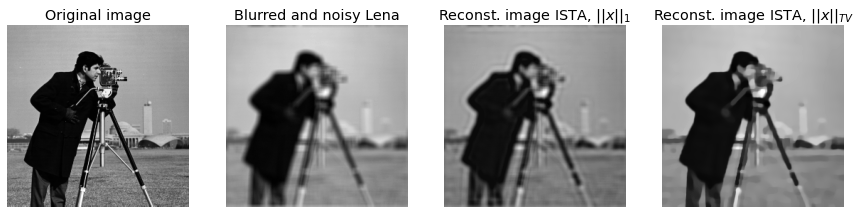

In [17]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 4, 1)
_ = ax1.imshow(x, cmap='gray')
_ = ax1.axis('off')
_ = ax1.set_title('Original image')
ax2 = fig.add_subplot(1, 4, 2)
_ = ax2.imshow(y, cmap='gray')
_ = ax2.axis('off')
_ = ax2.set_title('Blurred and noisy Lena')
ax3 = fig.add_subplot(1, 4, 3)
_ = ax3.imshow(ret_1norm_IST['sol'], cmap='gray')
_ = ax3.axis('off')
_ = ax3.set_title('Reconst. image ISTA, $\|\| x \|\|_1$')
ax4 = fig.add_subplot(1, 4, 4)
_ = ax4.imshow(ret_tv_norm_IST['sol'], cmap='gray')
_ = ax4.axis('off')
_ = ax4.set_title('Reconst. image ISTA, $\|\| x \|\|_{TV}$')


plt.savefig('FISTA_IST_debluring'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

# Results of part 1

<ipython-input-18-0642034e93ba>:7: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  axes[0][1].set_title('SALSA, PSNR = {} dB'.format(np.round(compare_psnr(x, x_salsa_soft), 3)))
<ipython-input-18-0642034e93ba>:10: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  axes[1][0].set_title('FISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_1norm['sol']), 3)))
<ipython-input-18-0642034e93ba>:13: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  axes[1][1].set_title('ISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_1norm_IST['sol']), 3)))


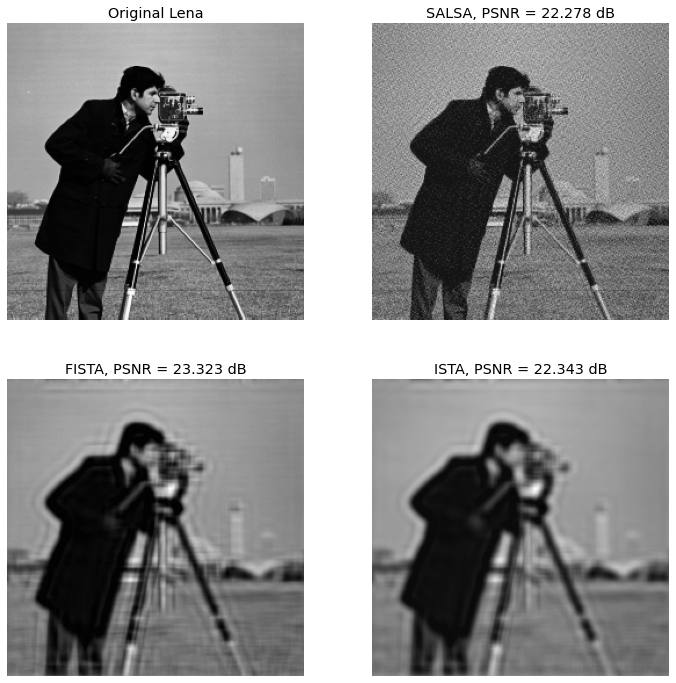

In [18]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)
axes[0][0].imshow(x, cmap='gray')
axes[0][0].set_title('Original Lena')
axes[0][0].axis('off')
axes[0][1].imshow(x_salsa_soft, cmap='gray')
axes[0][1].set_title('SALSA, PSNR = {} dB'.format(np.round(compare_psnr(x, x_salsa_soft), 3)))
axes[0][1].axis('off')
axes[1][0].imshow(ret_1norm['sol'], cmap='gray')
axes[1][0].set_title('FISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_1norm['sol']), 3)))
axes[1][0].axis('off')
axes[1][1].imshow(ret_1norm_IST['sol'], cmap='gray')
axes[1][1].set_title('ISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_1norm_IST['sol']), 3)))
axes[1][1].axis('off')

plt.savefig('1_norm_debluring_comparing'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

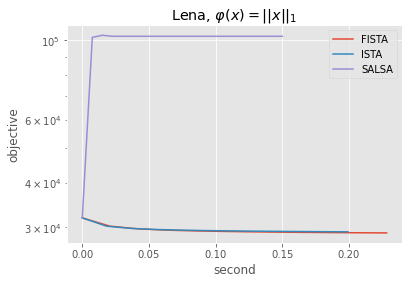

In [19]:
gf_soft = [x + 10.20*10e3  for x in f_soft]
s = gf_soft[0] - ret_1norm['objective'][0][0] - ret_1norm['objective'][0][1]
gf_soft[0] = gf_soft[0] - s
plt.semilogy(np.linspace(0., ret_1norm['time'], ret_1norm['niter']+1), np.sum(ret_1norm['objective'], axis=1), label = 'FISTA')
plt.semilogy(np.linspace(0., ret_1norm_IST['time'], ret_1norm_IST['niter']+1), np.sum(ret_1norm_IST['objective'], axis=1), label = 'ISTA')
plt.semilogy(np.linspace(0., 0.15 , len(gf_soft)), gf_soft, label = 'SALSA')
plt.legend()
plt.xlabel('second')
plt.ylabel('objective')
#plt.titile('')

plt.savefig('objective_1norm_lena'+ '.pdf', format = 'pdf', bbox_inches = 'tight')
plt.title('Lena, $\\varphi(x) = \|\| x \|\|_1$')
plt.show()

In [20]:
gf_soft

[31884.743394690493,
 102000.23137971334,
 103416.8464079998,
 102726.9434745335,
 102724.22700464501,
 102724.04449714604,
 102723.95191407228,
 102723.88164468064,
 102723.82456675517,
 102723.77751628491,
 102723.74272884212,
 102723.71629531152,
 102723.69542746937,
 102723.67374105875,
 102723.6553330464,
 102723.64118187592,
 102723.6285089148,
 102723.61717678532,
 102723.6073183985,
 102723.59917357293,
 102723.59221180469]

In [21]:
ret_1norm['objective']

[[28940.44350795423, 2944.2998867362658],
 [28628.19391348511, 1607.6016391069488],
 [28641.239052791272, 1080.1413034220914],
 [28641.42953337019, 837.3817729142878],
 [28636.36057155415, 698.8675592191612],
 [28630.439975555895, 605.4687816695437],
 [28625.700860319917, 534.8151981499973],
 [28622.323757563507, 478.00435451453006],
 [28620.02805809133, 430.922925506577],
 [28618.306940611714, 391.61791502770086],
 [28616.985738936542, 358.8016067911517],
 [28616.17301484796, 331.4834523701669]]

<ipython-input-22-e6837aee5415>:7: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  axes[0][1].set_title('SALSA, PSNR = {} dB'.format(np.round(compare_psnr(x,x_salsa), 3)))
<ipython-input-22-e6837aee5415>:10: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  axes[1][0].set_title('FISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_tv_norm['sol']), 3)))
<ipython-input-22-e6837aee5415>:13: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  axes[1][1].set_title('ISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_tv_norm_IST['sol']), 3)))


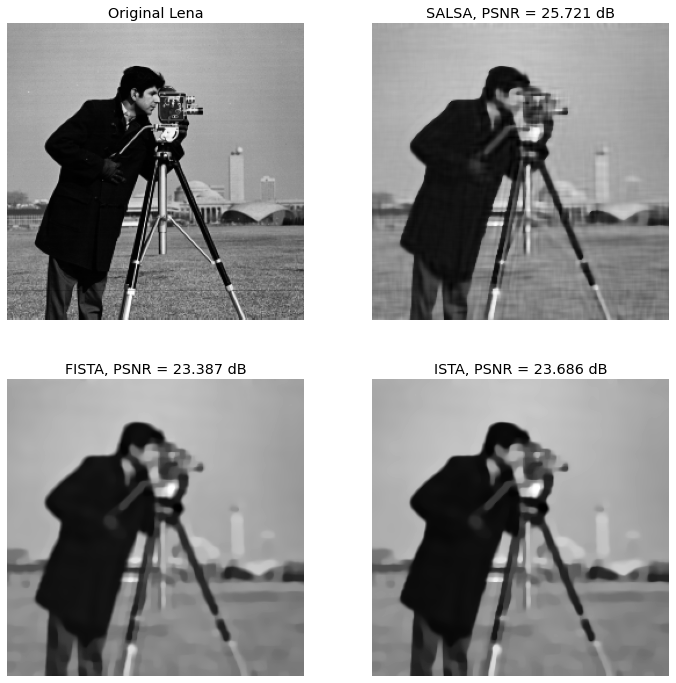

In [22]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)
axes[0][0].imshow(x, cmap='gray')
axes[0][0].set_title('Original Lena')
axes[0][0].axis('off')
axes[0][1].imshow(x_salsa, cmap='gray')
axes[0][1].set_title('SALSA, PSNR = {} dB'.format(np.round(compare_psnr(x,x_salsa), 3)))
axes[0][1].axis('off')
axes[1][0].imshow(ret_tv_norm['sol'], cmap='gray')
axes[1][0].set_title('FISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_tv_norm['sol']), 3)))
axes[1][0].axis('off')
axes[1][1].imshow(ret_tv_norm_IST['sol'], cmap='gray')
axes[1][1].set_title('ISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_tv_norm_IST['sol']), 3)))
axes[1][1].axis('off')


plt.savefig('tv_norm_debluring_comparing'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

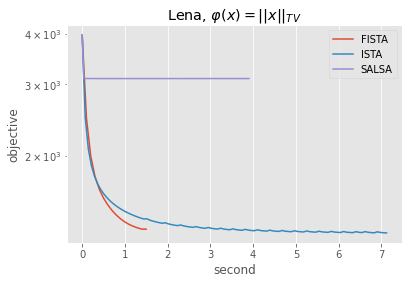

In [23]:
g = [x + 3100  for x in f]
s1 = g[0] - ret_tv_norm['objective'][0][0] - ret_tv_norm['objective'][0][1]
g[0] = g[0] - s1

plt.semilogy(np.linspace(0., ret_tv_norm['time'], ret_tv_norm['niter']+1), np.sum(ret_tv_norm['objective'], axis=1), label = 'FISTA')
plt.semilogy(np.linspace(0., ret_tv_norm_IST['time'], ret_tv_norm_IST['niter']+1), np.sum(ret_tv_norm_IST['objective'], axis=1), label = 'ISTA')
plt.semilogy(np.linspace(0., 3.9 , len(f)), g, label = 'SALSA')
plt.legend()
plt.xlabel('second')
plt.ylabel('objective')
#plt.titile('')

plt.savefig('objective_tv_norm_Lena'+ '.pdf', format = 'pdf', bbox_inches = 'tight')
plt.title('Lena, $\\varphi(x) = \|\| x \|\|_{TV}$')
plt.show()